In [64]:
# Load tidyverse
library(tidyverse)
# Install required packages
install.packages("readr")

# Load the necessary libraries
library(readr)
library(httr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [65]:
# Kaggle has no internet access for direct file download, so use httr to download the file
url <- "https://dax-cdn.cdn.appdomain.cloud/dax-airline/1.0.1/lax_to_jfk.tar.gz"

# Use httr to download the file
GET(url, write_disk("lax_to_jfk.tar.gz", overwrite = TRUE))

Response [https://dax-cdn.cdn.appdomain.cloud/dax-airline/1.0.1/lax_to_jfk.tar.gz]
  Date: 2024-10-15 06:45
  Status: 200
  Content-Type: application/x-gzip
  Size: 58.4 kB
<ON DISK>  /kaggle/working/lax_to_jfk.tar.gzNULL

In [66]:
# Untar the file in Kaggle (no need for tar = "internal")
untar("lax_to_jfk.tar.gz")

# Read the CSV file
sub_airline <- read_csv("lax_to_jfk/lax_to_jfk.csv",
                        col_types = cols('DivDistance' = col_number(), 
                                         'DivArrDelay' = col_number()))

# Check the first few rows
head(sub_airline)

Month,DayOfWeek,FlightDate,Reporting_Airline,Origin,Dest,CRSDepTime,CRSArrTime,DepTime,ArrTime,⋯,ArrDelayMinutes,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepDelay,DepDelayMinutes,DivDistance,DivArrDelay
<dbl>,<dbl>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,5,2003-03-28,UA,LAX,JFK,2210,0615,2209,0617,⋯,2,NA,NA,NA,NA,NA,-1,0,NA,NA
11,4,2018-11-29,AS,LAX,JFK,1045,1912,1049,1851,⋯,0,NA,NA,NA,NA,NA,4,4,NA,NA
8,5,2015-08-28,UA,LAX,JFK,0805,1634,0757,1620,⋯,0,NA,NA,NA,NA,NA,-8,0,NA,NA
4,7,2003-04-20,DL,LAX,JFK,2205,0619,2212,0616,⋯,0,NA,NA,NA,NA,NA,7,7,NA,NA
11,3,2005-11-30,UA,LAX,JFK,0840,1653,0836,1640,⋯,0,NA,NA,NA,NA,NA,-4,0,NA,NA
4,1,1992-04-06,UA,LAX,JFK,1450,2308,1452,2248,⋯,0,NA,NA,NA,NA,NA,2,2,NA,NA


# Task 1: Data Inspection and Handling Missing Values

In [67]:
# 1. Inspect for missing values
print("Missing values summary:")
print(summary(is.na(sub_airline)))  
print(sapply(sub_airline, function(x) sum(is.na(x)))) # Missing values per column


[1] "Missing values summary:"
   Month         DayOfWeek       FlightDate      Reporting_Airline
 Mode :logical   Mode :logical   Mode :logical   Mode :logical    
 FALSE:2855      FALSE:2855      FALSE:2855      FALSE:2855       
                                                                  
   Origin           Dest         CRSDepTime      CRSArrTime     
 Mode :logical   Mode :logical   Mode :logical   Mode :logical  
 FALSE:2855      FALSE:2855      FALSE:2855      FALSE:2855     
                                                                
  DepTime         ArrTime         ArrDelay       ArrDelayMinutes
 Mode :logical   Mode :logical   Mode :logical   Mode :logical  
 FALSE:2855      FALSE:2855      FALSE:2855      FALSE:2855     
                                                                
 CarrierDelay    WeatherDelay     NASDelay       SecurityDelay  
 Mode :logical   Mode :logical   Mode :logical   Mode :logical  
 FALSE:369       FALSE:369       FALSE:369       FAL

In [68]:
# 2. Handling missing values in specific columns
# Replace and remove
sub_airline_cleaned <- sub_airline %>%
  mutate(across(c(CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay), ~replace_na(., 0))) %>%
  select(-DivDistance, -DivArrDelay)

In [69]:
print("Missing values summary after handling structural NAs:")
print(summary(is.na(sub_airline_cleaned))) 
print(sapply(sub_airline_cleaned, function(x) sum(is.na(x))))

[1] "Missing values summary after handling structural NAs:"
   Month         DayOfWeek       FlightDate      Reporting_Airline
 Mode :logical   Mode :logical   Mode :logical   Mode :logical    
 FALSE:2855      FALSE:2855      FALSE:2855      FALSE:2855       
   Origin           Dest         CRSDepTime      CRSArrTime     
 Mode :logical   Mode :logical   Mode :logical   Mode :logical  
 FALSE:2855      FALSE:2855      FALSE:2855      FALSE:2855     
  DepTime         ArrTime         ArrDelay       ArrDelayMinutes
 Mode :logical   Mode :logical   Mode :logical   Mode :logical  
 FALSE:2855      FALSE:2855      FALSE:2855      FALSE:2855     
 CarrierDelay    WeatherDelay     NASDelay       SecurityDelay  
 Mode :logical   Mode :logical   Mode :logical   Mode :logical  
 FALSE:2855      FALSE:2855      FALSE:2855      FALSE:2855     
 LateAircraftDelay  DepDelay       DepDelayMinutes
 Mode :logical     Mode :logical   Mode :logical  
 FALSE:2855        FALSE:2855      FALSE:2855     
 

1. Columns with the Most Missing Values (Initially):

The initial inspection revealed that DivDistance, DivArrDelay, CarrierDelay, 
WeatherDelay, NASDelay, SecurityDelay, and LateAircraftDelay had the most missing values. 
DivDistance and DivArrDelay were missing in all rows (2855 missing values each). 
The delay-related columns (CarrierDelay, etc.) had 2486 missing values each.

2. Pros and Cons of Missing Value Strategies:

Replacing NAs with 0 (for CarrierDelay, WeatherDelay, etc.):

Pros: This is the most appropriate strategy for these columns. The missingness is structural – a missing value indicates a delay of 0, not truly missing data. This preserves the information that there was no delay of that particular type.

Cons: If there were truly missing values mixed in (e.g., data entry errors), this method would mask them. However, given the large number of missing values and the nature of these variables, this is less likely.

Removing columns DivDistance and DivArrDelay:

Pros: Necessary because these columns provided no information (100% missing values). Removing them simplifies the dataset and prevents errors in subsequent analysis.

Cons: Loss of potential information if these columns had been populated. However, in this case, the loss is unavoidable.

3. Changes in Dataset Dimensions:

Original dataset: 2855 rows x 21 columns

After handling: 2855 rows x 19 columns

# Task 2


In [77]:
# Simple scaling (dividing by max)
sub_airline_cleaned <- sub_airline_cleaned %>%
  mutate(ArrDelay_simple_scaled = ArrDelay / max(ArrDelay, na.rm = TRUE),
         DepDelay_simple_scaled = DepDelay / max(DepDelay, na.rm = TRUE))

In [78]:
# Min-Max Scaling
sub_airline_cleaned <- sub_airline_cleaned %>%
  mutate(ArrDelay_minmax_scaled = (ArrDelay - min(ArrDelay, na.rm = TRUE)) / 
                                  (max(ArrDelay, na.rm = TRUE) - min(ArrDelay, na.rm = TRUE)),
         DepDelay_minmax_scaled = (DepDelay - min(DepDelay, na.rm = TRUE)) / 
                                  (max(DepDelay, na.rm = TRUE) - min(DepDelay, na.rm = TRUE)))

In [79]:
# Z-score Standardization
sub_airline_cleaned <- sub_airline_cleaned %>%
  mutate(ArrDelay_zscore = (ArrDelay - mean(ArrDelay, na.rm = TRUE)) / sd(ArrDelay, na.rm = TRUE),
         DepDelay_zscore = (DepDelay - mean(DepDelay, na.rm = TRUE)) / sd(DepDelay, na.rm = TRUE))

In [81]:
# 3. Compare the results using histograms
install.packages("ggplot2")
library(ggplot2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [82]:
# ArrDelay comparison
p1 <- ggplot(sub_airline_cleaned, aes(x = ArrDelay_simple_scaled)) + 
      geom_histogram(bins = 30, fill = "blue", alpha = 0.6) + 
      ggtitle("ArrDelay: Simple Scaling") + 
      theme_minimal()

p2 <- ggplot(sub_airline_cleaned, aes(x = ArrDelay_minmax_scaled)) + 
      geom_histogram(bins = 30, fill = "green", alpha = 0.6) + 
      ggtitle("ArrDelay: Min-Max Scaling") + 
      theme_minimal()

p3 <- ggplot(sub_airline_cleaned, aes(x = ArrDelay_zscore)) + 
      geom_histogram(bins = 30, fill = "red", alpha = 0.6) + 
      ggtitle("ArrDelay: Z-Score Standardization") + 
      theme_minimal()

In [83]:
# DepDelay comparison
p4 <- ggplot(sub_airline_cleaned, aes(x = DepDelay_simple_scaled)) + 
      geom_histogram(bins = 30, fill = "blue", alpha = 0.6) + 
      ggtitle("DepDelay: Simple Scaling") + 
      theme_minimal()

p5 <- ggplot(sub_airline_cleaned, aes(x = DepDelay_minmax_scaled)) + 
      geom_histogram(bins = 30, fill = "green", alpha = 0.6) + 
      ggtitle("DepDelay: Min-Max Scaling") + 
      theme_minimal()

p6 <- ggplot(sub_airline_cleaned, aes(x = DepDelay_zscore)) + 
      geom_histogram(bins = 30, fill = "red", alpha = 0.6) + 
      ggtitle("DepDelay: Z-Score Standardization") + 
      theme_minimal()

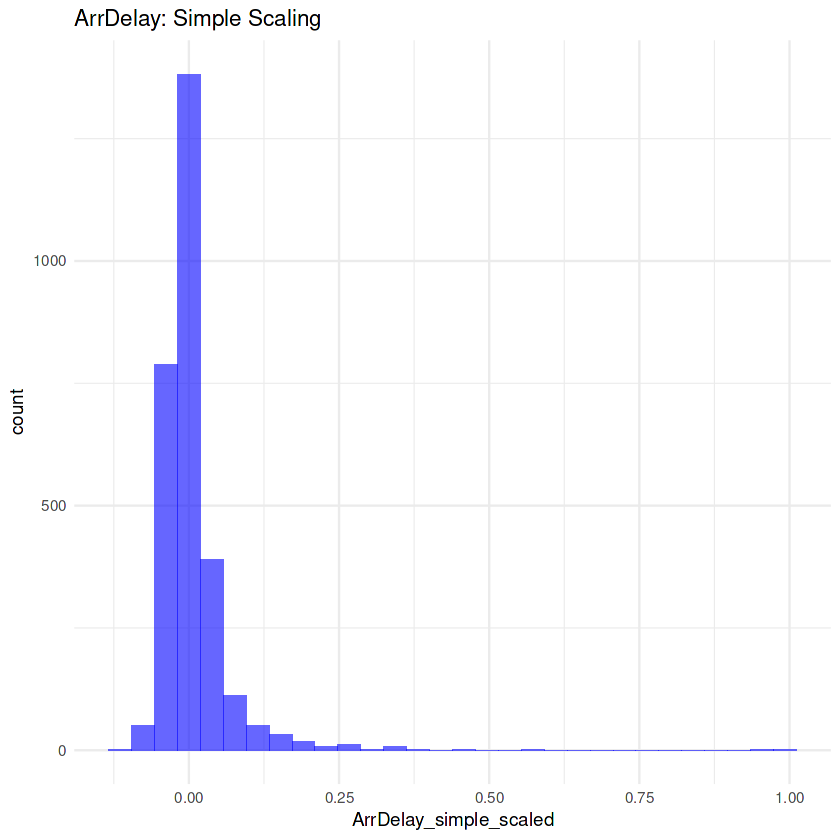

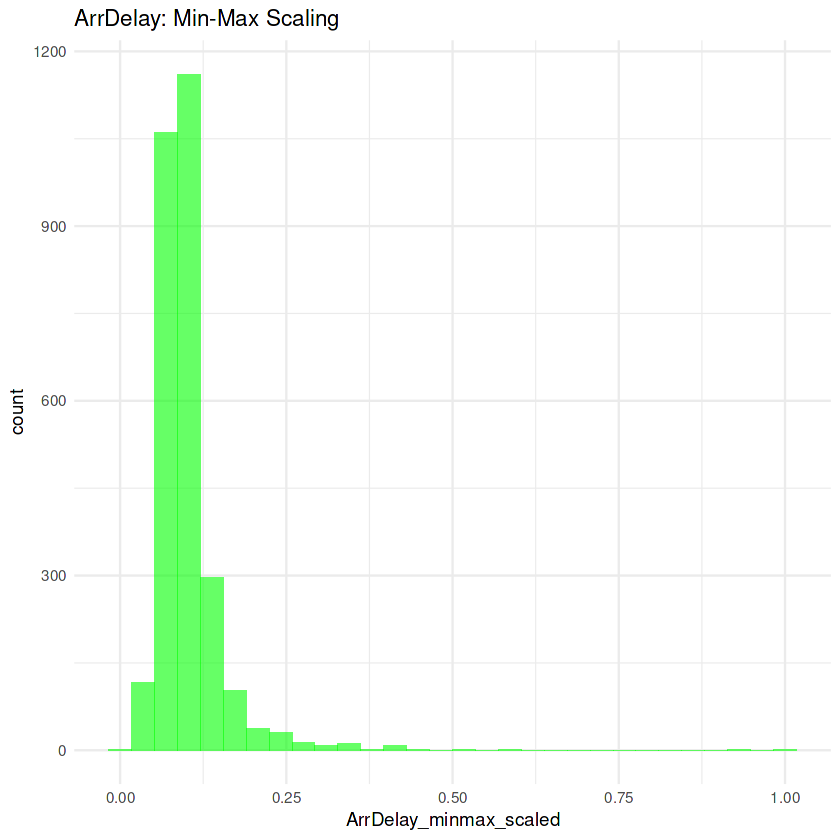

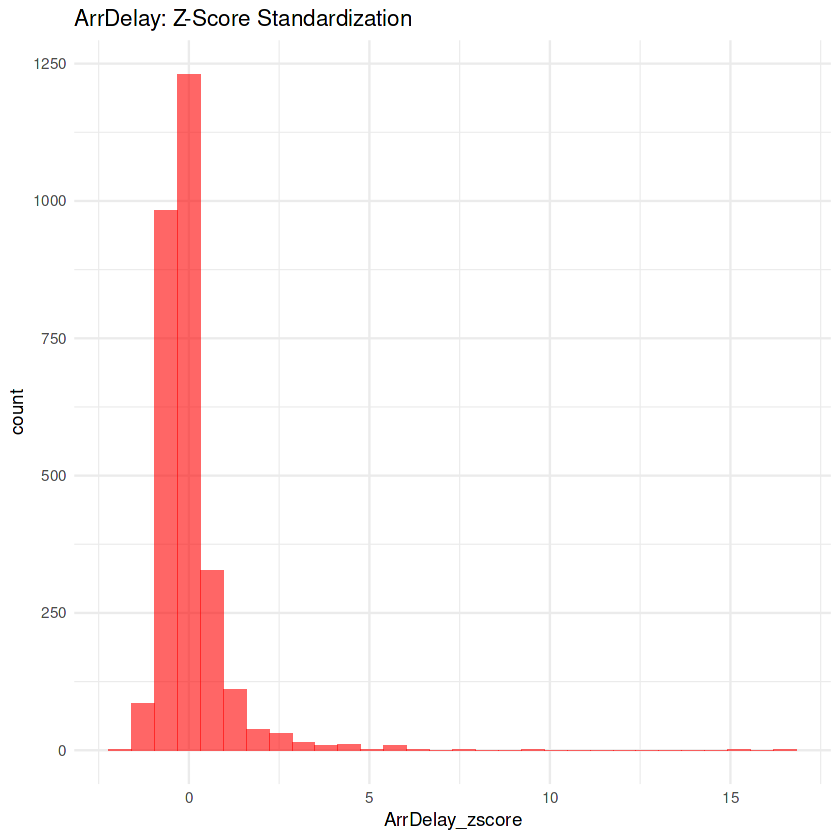

In [84]:
print(p1)
print(p2)
print(p3)

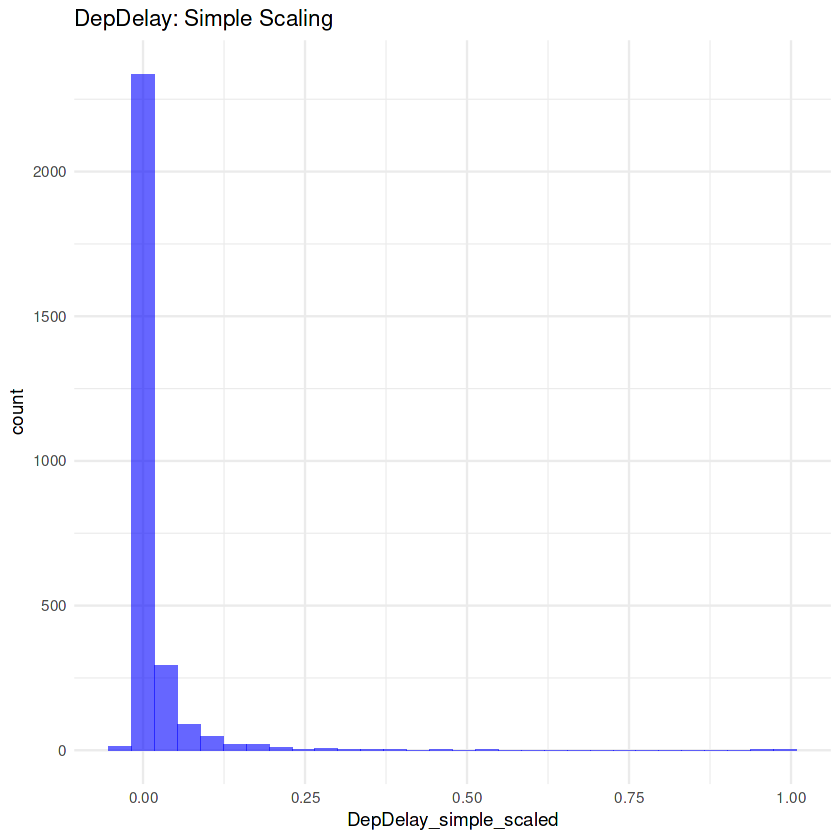

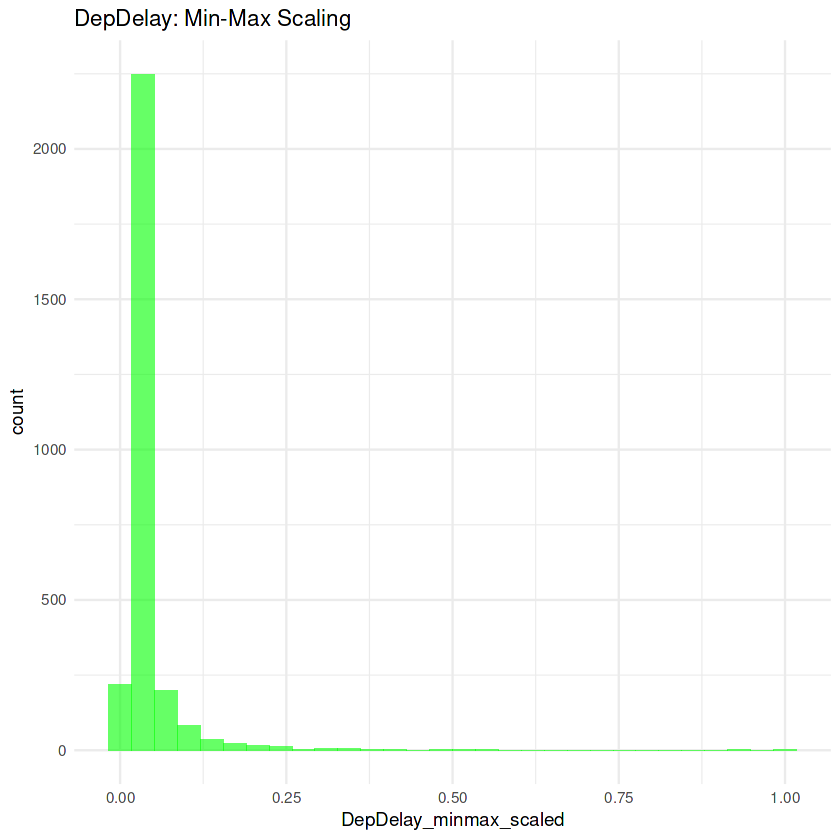

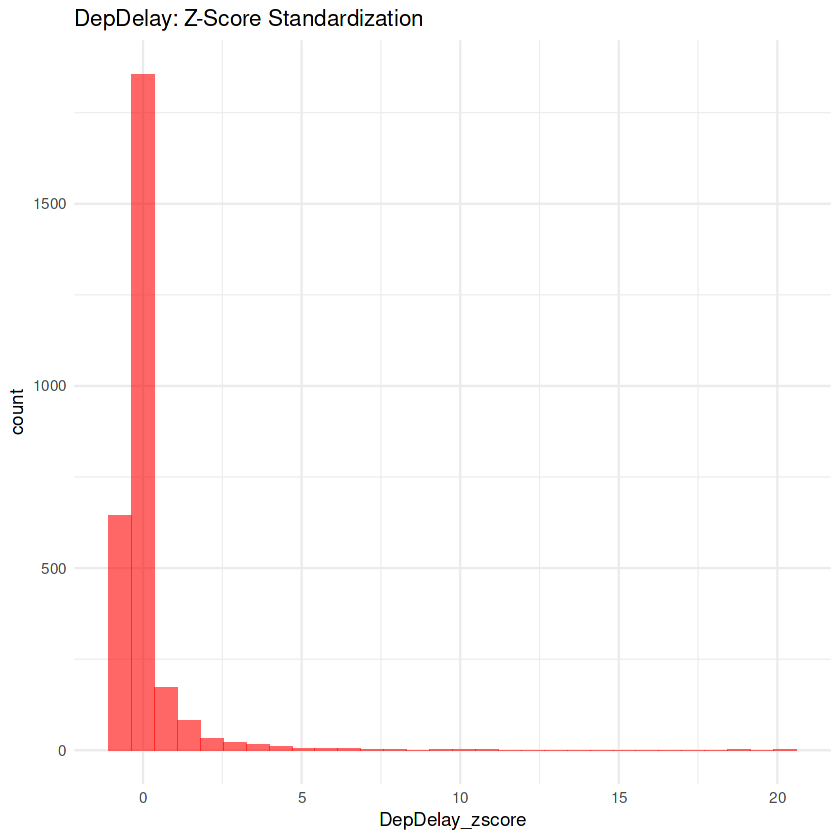

In [85]:
print(p4)
print(p5)
print(p6)

Distribution Changes:

    Simple Scaling: The data is rescaled between 0 and 1 based on the maximum value. The shape of the distribution remains the same, but it is compressed into a smaller range.

    Min-Max Scaling: Similar to simple scaling, but ensures the minimum value is 0 and the maximum is 1. The distribution is stretched or squeezed into the 0–1 range.

    Z-score Standardization: Centers the data around 0 with a standard deviation of 1. It transforms the distribution to show how far each value is from the mean, but the shape of the distribution is preserved.

Most Appropriate Normalization:

    Z-score Standardization is often the most appropriate when data has outliers, as it scales based on the mean and standard deviation, making it less sensitive to extreme values.
    
    Min-Max Scaling can be useful if you need all values to be between 0 and 1, but it can be skewed by outliers.

    Simple Scaling may be less suitable because it’s entirely dependent on the maximum value, which can distort the scaling if outliers exist.

Impact on Further Analysis:

    Z-score Standardization is generally better for statistical analyses like regression or machine learning, where the data needs to be centered and comparable.

    Min-Max Scaling is more useful for algorithms that rely on specific ranges (e.g., neural networks) but may distort distances in the presence of outliers.

    Simple Scaling might not work well for more complex analysis since it doesn't take data distribution into account.

# Task 3

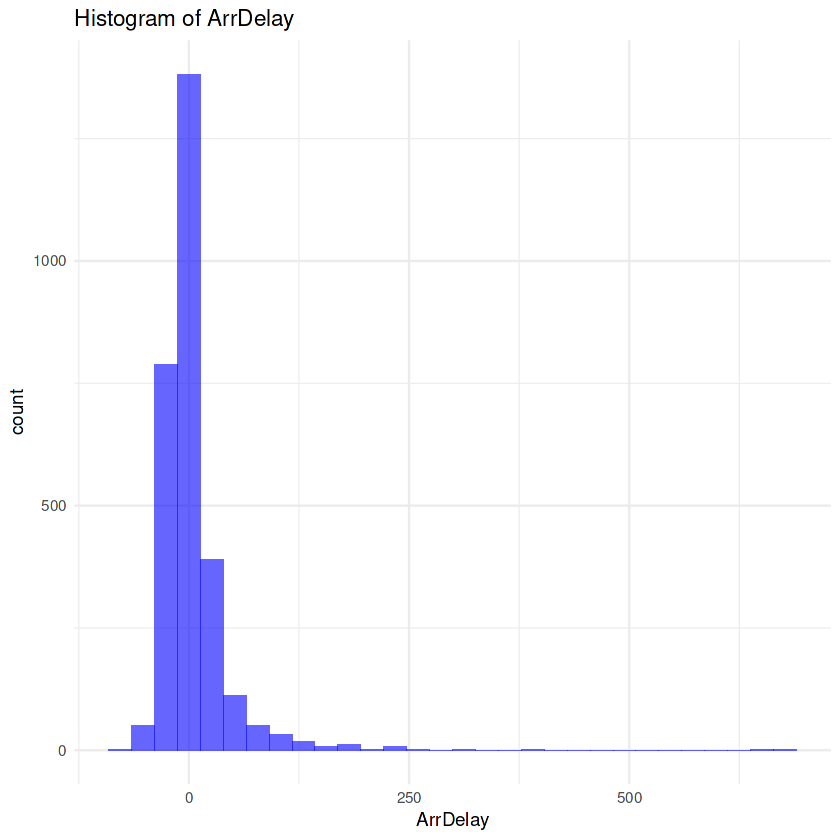

In [86]:
# 1. Create a histogram of the ArrDelay column
p_hist <- ggplot(sub_airline_cleaned, aes(x = ArrDelay)) + 
          geom_histogram(bins = 30, fill = "blue", alpha = 0.6) + 
          ggtitle("Histogram of ArrDelay") + 
          theme_minimal()

# Print the histogram
print(p_hist)

In [87]:
# 2. Implement a binning strategy: Divide ArrDelay into 4 bins (quantiles)
sub_airline_cleaned <- sub_airline_cleaned %>%
  mutate(ArrDelay_bins = cut(ArrDelay, 
                             breaks = 4, # 4 bins
                             labels = c("Very Early", "On Time", "Moderate Delay", "Severe Delay"),
                             include.lowest = TRUE))

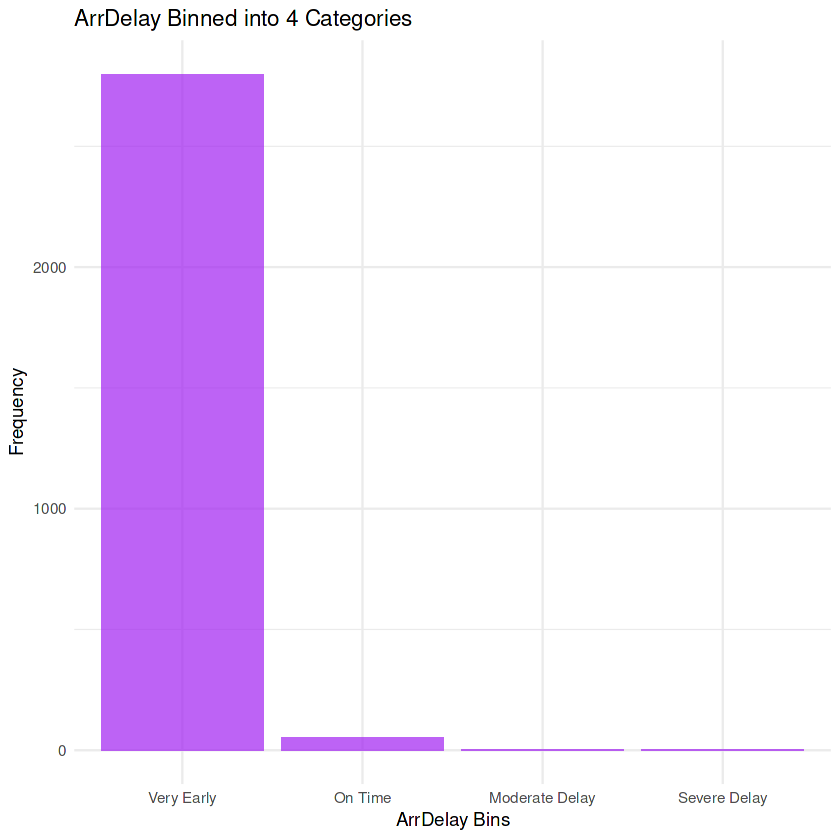

In [88]:
# 3. Visualize the results: Bar plot of the binned data
p_bins <- ggplot(sub_airline_cleaned, aes(x = ArrDelay_bins)) + 
          geom_bar(fill = "purple", alpha = 0.7) + 
          ggtitle("ArrDelay Binned into 4 Categories") + 
          xlab("ArrDelay Bins") + 
          ylab("Frequency") + 
          theme_minimal()

# Print the binned data visualization
print(p_bins)

Insights from the Histogram:

    The histogram shows that most flights have small or moderate delays, with fewer flights experiencing very large delays. There's also a significant portion with early arrivals.

Choice of Bins:

    I chose 4 bins to categorize the flights into meaningful groups: "Very Early", "On Time", "Moderate Delay", and "Severe Delay". This helps simplify the data and makes it easier to analyze delays in broader categories.
    
    Fewer bins would lose detail, while too many bins might make the data harder to interpret.

Usefulness of Binning:

    Binning is helpful in summarizing continuous data into manageable categories. It can help identify patterns or trends, such as whether flights are mostly on time or delayed, which is useful for reporting and further analysis like building classification models.

# Task 4

In [89]:
library(dplyr)

In [90]:
# 1. Create dummy variables for the "Reporting_Airline" column
# Use model.matrix to create dummy variables for categorical data
airline_dummies <- model.matrix(~ Reporting_Airline - 1, data = sub_airline_cleaned)
airline_dummies <- as.data.frame(airline_dummies)  # Convert to data frame

In [91]:
# 2. Create indicator variables for the "Month" column using the "DepDelay" values
# Create dummy variables for "Month"
month_dummies <- model.matrix(~ Month - 1, data = sub_airline_cleaned)
month_dummies <- as.data.frame(month_dummies)  # Convert to data frame

In [92]:
# Multiply the dummy variables by "DepDelay" values instead of using 1s and 0s
month_dummies_depdelay <- month_dummies * sub_airline_cleaned$DepDelay

In [93]:
# 3. Combine the original data with the new dummy variables
sub_airline_transformed <- cbind(sub_airline_cleaned, airline_dummies, month_dummies_depdelay)

In [94]:
# Display the first few rows to verify
head(sub_airline_transformed)

,Month,DayOfWeek,FlightDate,Reporting_Airline,Origin,Dest,CRSDepTime,CRSArrTime,DepTime,ArrTime,⋯,Reporting_AirlineAA,Reporting_AirlineAS,Reporting_AirlineB6,Reporting_AirlineDL,Reporting_AirlineHP,Reporting_AirlinePA (1),Reporting_AirlineTW,Reporting_AirlineUA,Reporting_AirlineVX,Month
,<dbl>,<dbl>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,5,2003-03-28,UA,LAX,JFK,2210,0615,2209,0617,⋯,0,0,0,0,0,0,0,1,0,-3
2,11,4,2018-11-29,AS,LAX,JFK,1045,1912,1049,1851,⋯,0,1,0,0,0,0,0,0,0,44
3,8,5,2015-08-28,UA,LAX,JFK,0805,1634,0757,1620,⋯,0,0,0,0,0,0,0,1,0,-64
4,4,7,2003-04-20,DL,LAX,JFK,2205,0619,2212,0616,⋯,0,0,0,1,0,0,0,0,0,28
5,11,3,2005-11-30,UA,LAX,JFK,0840,1653,0836,1640,⋯,0,0,0,0,0,0,0,1,0,-44
6,4,1,1992-04-06,UA,LAX,JFK,1450,2308,1452,2248,⋯,0,0,0,0,0,0,0,1,0,8


Dataset Structure Change:

    The dataset has more columns now because each category in Reporting_Airline and Month has been split into separate indicator (dummy) columns. For each airline, there's a new column (e.g., Reporting_Airline_AA), and for each month, there's a column multiplied by DepDelay.


Benefits:

    Clarity: Indicator variables make it easy to compare the effect of specific airlines or months on delays.
    Modeling: Many machine learning models (e.g., linear regression, decision trees) work better with numeric data, so converting categorical variables to numeric form (via dummies) makes the data ready for analysis.



Drawbacks:

    More Complexity: The dataset grows in size, which might increase computational costs and complexity.
    Multicollinearity Risk: If too many dummy variables are created without careful consideration, it might introduce multicollinearity issues (redundancy between variables).


Usefulness in Analysis:

    These indicator variables will be useful for regression or classification models, allowing the analysis of how specific airlines or months impact delays. They help to capture categorical patterns in a numeric-friendly format for machine learning.

# Task 5

In [95]:
# 1. Count the number of data points for each airline
airline_counts <- sub_airline_cleaned %>%
  group_by(Reporting_Airline) %>%
  summarise(count = n())

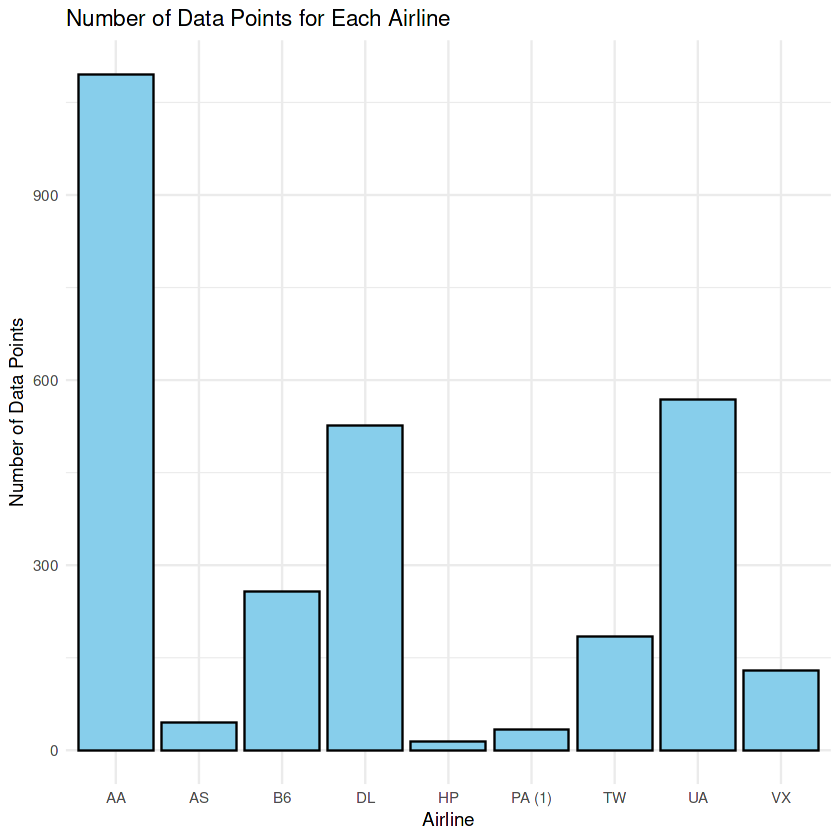

In [96]:
# 2. Create a bar plot
p_airline <- ggplot(airline_counts, aes(x = Reporting_Airline, y = count)) +
             geom_bar(stat = "identity", fill = "skyblue", color = "black") +
             ggtitle("Number of Data Points for Each Airline") +
             xlab("Airline") + 
             ylab("Number of Data Points") +
             theme_minimal()

# Print the bar plot
print(p_airline)

Airlines with the Most and Least Data Points:

    The bar plot shows which airlines have the most data points (likely the larger airlines) and which have the least data points (smaller airlines or those with fewer flights in the dataset).


Impact of Data Point Differences:

    Airlines with more data points will have stronger statistical significance in analysis, while airlines with fewer data points may provide less reliable results. This imbalance could skew conclusions if not handled carefully, especially in modeling or predictions.


Additional Visualization Suggestion:

    A box plot showing the distribution of ArrDelay or DepDelay for each airline could provide insights into how delays vary between airlines, helping to understand if certain airlines tend to have more delays than others.